# From PLATO Flares WG technical note

Flares were injected using the flare template of Davenport et al. (2014). The input parameters for the injection
were:
- The flare start time chosen randomly from the given light curve.
- A flare duration distribution consisting of the broken power law given in Davenport et al. (2014, their Fig. 7). ![Fig7\label{mylabel}](Davenport_2014_Fig7.png)
- The relation between flare duration and flare amplitude by Hawley et al. (2014) including one order of
magnitude scatter in amplitude for a given duration.
- The flare rate observed in K2 short cadence M dwarf flares studied by Raetz et al. (2020a) for the given
spectral type and rotation period.


In particular, a flare was created by firstly drawing a flare duration from the broken power law, computing the
amplitude for this duration using the Hawley et al. (2014) relation but choosing it randomly within one order of
magnitude around the calculated value, and injecting it at a random time in the light curve (overlapping flares
were permitted in order to simulate multi-peak flares). Using the flare rate extracted from Raetz et al. (2020a),
a total number of 155 flares were injected into the full 2-year light curve. The broken power law flare duration
distribution for those 155 injected flares is shown in Fig. 7 and the final simulated light curve with injected flares
in Fig. 8.


![Fig7\label{mylabel}](Fig7.png)
![Fig8\label{mylabel2}](Fig8.png)

# translated in Daxenese:

- pick random flare time
- Create grid of flare duration 
- based on duration is N flares from Davenport result (fig 7)
- based on duration is also the amplitude
- based on Prot is flare rate

# Tobias sez:

Hi Dax, cc Stefanie,

Sure thing, please find the Python file attached. 
The code is not fully documented, but the most important steps for flare injection are explained in the comments. 

## The function you need is inject_flares(), which takes as arguments:
## - Time and flux values of the light curve as a list/array/etc,
## - The flare rate as a float, given in flares/day,
## - newTemplate as a bool (False by default), which indicates whether the „new“ flare template we discussed should be used, otherwise the Davenport 2014 template will be used. 

It returns the new flux data with injected flares, and the ‚flare parameters‘, which is a list of dictionaries containing information of each injected flare.
All previously defined functions are used within inject_flares(), so you don’t really need to bother unless you want to take a closer look. Again, the important steps are explained with comments. 

The flare injection consists of the following steps:
- Generate number of flares with input flare rate (flares/day)
- Generate random flare durations with PL distribution from Davenport et al.
- Infer flare amplitudes from flare durations using relation from Hawley et al.
- Generate random flare start times with uniform distribution
- Flare flux data points  f$_{Ff}$  are generated with chosen template
- Flare data is added to the light curve:  f$_{Out}$ = f$_{In}$ + f$_{F}$ 

The Davenport PL distribution refers to fig. 7 (top) of the linked paper. However, we changed the broken PL to a single one, extrapolating the steeper of the two down to short durations, since we interpreted the break as an effect of detection rather than of physical processes.
The Hawley relation refers to fig. 10 (right) of the respective paper, which shows a relation between flare durations and amplitudes.
Finally, you will find some functions below which come in handy for quick looks at the new light curve, as well as some distributions of flare parameters. I hope they should be „plug-and-runnable“ and self-explanatory.

Please don’t hesitate to contact me if anything is unclear or if (God forbid) any bugs appear.
Have fun!

Cheers,
Tobi

# Tobias' functions

In [1]:
import numpy as np
import pandas as pd
# import powerlaw #(not used?)
import logging
from scipy.integrate import cumtrapz
from scipy.special import erfc
import copy
import matplotlib.pyplot as plt
from lmfit import Model


def time2norm(t, t0, tmax):
    return (t - tmax) / (tmax - t0)


def rise_function_norm(t, a):
    """
    Template from Davenport et. al., models the rise of the flare in normalized time units, valid for -1 <= t <= 0.
    :param t: Functional argument, normalized time value
    :param a: Flare amplitude
    :return: Functional value
    """
    f = 1 + 1.941 * t - 0.175 * t ** 2 - 2.246 * t ** 3 - 1.125 * t ** 4
    return a * f


def decay_function_norm(t, a):
    """
    Template from Davenport et. al., models the flare decay in normalized time units, valid for 0 <= t.
    :param t: Functional argument, normalized time value
    :param a: Flare amplitude
    :return: Functional value
    """
    f = 0.689 * np.exp(-1.6 * t) + 0.303 * np.exp(-0.2783 * t)
    return a * f


def new_template_norm(t, a):
    # Copy-pasted from original code of Guadalupe Tovar Mendoza et al. 2022 flare template:
    # https://github.com/lupitatovar/Llamaradas-Estelares
    '''
        The equation that defines the shape for the Continuous Flare Model
        '''
    # Values were fit & calculated using MCMC 256 walkers and 30000 steps

    A, B, C, D1, D2, f1 = [0.9687734504375167, -0.251299705922117, 0.22675974948468916,
                           0.15551880775110513, 1.2150539528490194, 0.12695865022878844]

    # We include the corresponding errors for each parameter from the MCMC analysis

    A_err, B_err, C_err, D1_err, D2_err, f1_err = [0.007941622683556804, 0.0004073709715788909, 0.0006863488251125649,
                                                   0.0013498012884345656, 0.00453458098656645, 0.001053149344530907]

    f2 = 1 - f1

    eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
           * erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2
                                                            * np.exp(
                -D2 * t + ((B / C) + (D2 * C / 2)) ** 2) * erfc(((B - t) / C) + (C * D2 / 2)))
    return eqn * a


def random_number_PL(alpha, x0, x1):
    y = np.random.random()  # Seed random number
    beta = 1 - alpha  # Help variable to make the next formula more readable
    x = (x0**beta * (1 - y) + x1**beta * y)**(1 / beta)  # Inverse method
    # For explanation see:
    # https://mathworld.wolfram.com/RandomNumber.html and references therein,
    # https://en.wikipedia.org/wiki/Inverse_transform_sampling#Definition,
    # https://en.wikipedia.org/wiki/Probability_integral_transform
    return x


def random_flare_duration(alpha=None): # in units of minutes
    ran_nr = np.random.random()  # Random float between 0 and 1

    # Previously:
    # if ran_nr < 0.85:  # 85% of all flares:
    if ran_nr <= -1:  # 0% of flares --> Changed to single PL distribution.
        # Duration between 2 and 20 minutes, PL index of 1.25
        if alpha is not None:
            min_dur, max_dur = 2, 20
        else:
            alpha, min_dur, max_dur = 1.25, 2, 20
    else:  # 100% of all flares (previously 15%):
        # Duration between 2 (previously 20) and 320 minutes, PL index of 2.99
        if alpha is not None:
            min_dur, max_dur = 2, 320
        else:        
            alpha, min_dur, max_dur = 2.99, 2, 320  # Previously: Second parameter was 20

    flare_dur = random_number_PL(alpha, min_dur, max_dur)
    return flare_dur


def hawley_log_amplitude(duration_minutes):
    # Correlation from Hawley et al. (2014) Fig 10, read from plot:
    # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    log_amp = 1.3681783243659 * np.log10(duration_minutes) - 3.9563566487317
    # Consider variation of correlation of ~1 order of magnitude.
    amp = log_amp - 0.5 + np.random.random()

    return amp


def generate_flare_parameters(time, lc_dur,alpha=None): #lc_dur is time span of lc?
    # Duration:
    flare_dur_mins = random_flare_duration(alpha)  # Generate random flare duration, value in mins.
    flare_dur_days = flare_dur_mins / (60 * 24)  # Convert to days

    # Start time:
    flare_start = time[0] + lc_dur * np.random.random()  # Random flare start time, can be close to edge of time array

    # Amplitude:
    log_amp = hawley_log_amplitude(flare_dur_mins)  # Logarithm of amplitude derived from duration with Hawley relation
    amp = 10**log_amp  # Convert to actual amplitude value

    return flare_dur_mins, flare_dur_days, flare_start, amp


def equivalent_duration(flare_time, flare_flux,input_median):
    from scipy.integrate import cumtrapz
    import numpy as np
    if len(flare_time) == 1:
        return 0  # TODO: This should be cadence (?)
    #return cumtrapz(flare_flux, flare_time)[-1] * 24 * 3600 #in seconds
    flux = flare_flux #- np.nanmedian(flare_flux) #centered on zero
    if np.round(np.nanmedian(flux))==0:        
        y = flux+input_median
    if np.round(np.nanmedian(flux))==1:        
        y = flux
    ED = np.abs(np.trapz(y, x=(flare_time)))
    return ED


def generate_flare(t_flare, flare_start, t_max, amp):
    # Normalized time units of flare: Start at 0, peak at 1, end at 13
    t_norm = time2norm(t_flare, flare_start, t_max)

    t_norm_rise = t_norm[t_norm < 0]  # Flare rise between 0 and 1
    flare_rise = rise_function_norm(t_norm_rise, amp)  # Generate flux data of flare rise

    t_norm_decay = t_norm[t_norm >= 0]  # Flare decay between 1 and 13
    flare_decay = decay_function_norm(t_norm_decay, amp)  # Generate flux data of flare decay

    # Concatenate rise and decay to obtain flux data of the whole flare:
    flare_flux = np.concatenate((flare_rise, flare_decay))
    return flare_flux


def generate_flare_new(t_flare, flare_start, t_max, amp):
    # Normalized time units of flare: Start at 0, peak at 1, end at 13
    t_norm = time2norm(t_flare, flare_start, t_max)
    flare_flux = new_template_norm(t_norm, amp)  # Generate flux data
    return flare_flux
    
    
def inject_flares(time, flux, flare_rate,alpha=None, newTemplate=False):
    time = np.array(time)
    flux = np.array(flux)
    input_median = np.nanmedian(flux)

    # Generate copy of flux so the original is not overwritten:
    flux = copy.deepcopy(flux)

    # Input and LC parameters:
    lc_len = len(time)  # LC length, in data points TODO: Do I need this?
    lc_dur = time[-1] - time[0]  # LC duration, in days
    n_flares = int(np.round(flare_rate * lc_dur))  # Total number of flares to be injected
    print(f'{n_flares} flares will be injected.')

    # List with dictionaries of injection parameters, will be filled throughout the process:
    flare_params = []

    for i in range(n_flares):  # Loop over all flares to be injected
        params_dict = {}

        #
        # First generate flare parameters: Duration, start time, amplitude.
        flare_dur_mins, flare_dur_days, flare_start, amp = generate_flare_parameters(time, lc_dur,alpha)
        flare_end = flare_start + flare_dur_days  # Help variable

        #
        # Next, get indices of where the flare will be:
        cond = np.logical_and(time >= flare_start, time <= flare_end)
        flare_inds = np.argwhere(cond).flatten()
        
        if len(flare_inds) == 0:  # Flare might be very short and in between two data points.
            logging.debug(f'Flare number {i+1} is between two data points:'
                          f'\n\tStart: {flare_start:.2f}\n\tLength:{flare_dur_mins:.2f} mins')
            cond = time >= flare_start
            flare_inds = np.argwhere(cond)[0:1].flatten()  # Flare index corresponds to only one data point
        
        #
        # Now generate the flare data:
        t_flare = time[flare_inds]  # Time array of the flare
        t_max = flare_start + flare_dur_days / 13  # Theoretical peak of the flare, at 1/13 flare length

        # Generate flux data of the injected flare
        if newTemplate:
            flare_flux = generate_flare_new(t_flare, flare_start, t_max, amp)
        else:
            flare_flux = generate_flare(t_flare, flare_start, t_max, amp)
        
        ED = equivalent_duration(t_flare, flare_flux,input_median)  # Calculate equivalent duration of the flare

        flux[flare_inds] += flare_flux  # Add flare flux to regular lc flux.
    
        # Save some parameters:
#         params_dict['Indices'] = flare_inds
#         params_dict['Start Time (MJD)'] = flare_start
#         params_dict['Flare Peak Time (MJD)'] = t_max
#         params_dict['End Time (MJD)'] = flare_end
#         params_dict['Duration (mins)'] = flare_dur_mins
#         params_dict['Amplitude'] = amp
#         params_dict['N Points'] = len(t_flare)
#         params_dict['ED'] = ED
        params_dict['Indices'] = flare_inds
        params_dict['tstart'] = flare_start
        params_dict['tpeak'] = t_max
        params_dict['tstop'] = flare_end
        params_dict['dur'] = flare_dur_days # in days ,not minutes
        params_dict['Fpeak'] = amp
        params_dict['Npts'] = len(t_flare)
        params_dict['equiv_dur'] = ED
        flare_params.append(params_dict)  # Append dictionary to list of all flares

    return flux, flare_params


def plotInjected(time, flux_in, flux_out, flare_params, savePath=None):
    cond = flux_out != flux_in

    t_flares, f_flares = time[cond], flux_out[cond]  # Only injected flares
    t_rep, f_rep = t_flares, flux_in[cond]  # Data of the input LC that was replaced by flares

    fig, ax = plt.subplots(1, 1, dpi=175, tight_layout=True, figsize=[8.5, 4])

    ax.plot()
    ax.plot(time, flux_out, color='blueviolet', label='Flared LC', alpha=0.5, lw=0.5)
    ax.plot(time, flux_in, color='grey', alpha=0.5, ls=':', label='Original LC', lw=0.5)

    # Data points:
    # ax.scatter(t_flares, f_flares, color='fuchsia', label='Injected Flares')
    # ax.scatter(t_rep, f_rep, color='grey', alpha=0.5, ls=':')

    for flare in flare_params:
        inds = flare['Indices']
        t_flare, f_flare, f_rep = time[inds], flux_out[inds], flux_in[inds]
        plt.plot(t_flare, f_flare, color='fuchsia', label='Injected Flares', alpha=0.7, lw=0.5)
        # plt.plot(t_flare, f_rep, color='grey', alpha=0.5, ls=':')

    # Avoid duplicates in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Normalized Flux')

    if savePath:
        fig.savefig(savePath)
    fig.show()


def PLModel(alpha):
    def PL(x, norm):
        return norm*x**(1-alpha)
    return Model(PL)


def plotDurationDistribution(params_dict, info_det=None, savePath=None, brokenPL=False):
    df = pd.DataFrame(params_dict)
#     dur = df['Duration (mins)']
    dur = df['dur']*24*60


    fig, ax = plt.subplots(1, 1, dpi=150)
    bins = np.logspace(np.log10(np.min(dur)), np.log10(np.max(dur)),
                       100)

    counts, _, _ = ax.hist(dur, bins=bins, color='darkviolet', alpha=0.5, label='Injected')
    bincen = np.array([(bins[i + 1] + bins[i]) / 2 for i in range(len(bins) - 1)])

    theo_color = 'mediumblue'

    if brokenPL:
        cond1 = bincen <= 20
        counts1, bincen1 = counts[cond1], bincen[cond1]

        if len(counts1):
            PL1 = PLModel(1.25)
            fitres1 = PL1.fit(counts1, norm=1, x=bincen1)
            print(fitres1.params)
            ax.plot(bins, fitres1.eval(x=bins), color=theo_color, label='PL Index 1.25', ls='--')

        cond2 = bincen >= 20
        counts2, bincen2 = counts[cond2], bincen[cond2]
        if len(counts2):
            PL2 = PLModel(2.99)
            fitres2 = PL2.fit(counts2, norm=1, x=bincen2)
            print(fitres2.params)
            ax.plot(bins, fitres2.eval(x=bins), color=theo_color, label='PL Index 2.99', ls=':')

        ymin, ymax = ax.get_ylim()
        ax.vlines(20, ymin, ymax, color='grey', alpha=0.5)
        ax.set_ylim(ymin, ymax)

    else:
        PL = PLModel(2.99)
        fitres = PL.fit(counts, norm=1, x=bincen)
        print(fitres.params)
        ax.plot(bins, fitres.eval(x=bins), color=theo_color, label='PL Index 2.99', ls='--')

    # Plot detected:
    if info_det:
        df_det = pd.DataFrame(info_det)
#         dur_det = df_det['Duration (mins)']
        dur = df['dur']*24*60

        ax.hist(dur_det, bins=bins, color='lime', alpha=0.5, label='Recovered')

    ax.set_xlabel('Duration (min)')
    ax.set_ylabel('Frequency')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(top=1.1 * np.max(counts))
    ax.set_title('Injected Flare Duration Distribution')
    ax.legend()
    if savePath:
        fig.savefig(savePath)
    fig.show()


def plotHawleyRelation(params_dict, info_det=None, savePath=None):
    df = pd.DataFrame(params_dict)
#     amp = df['Amplitude']
#     dur = df['Duration (mins)']
    amp = df['Fpeak']
    dur = df['dur']*24*60

    fig, ax = plt.subplots(1, 1, dpi=150)
    ax.scatter(dur, amp, color='darkviolet', label='Injected Flares', marker='.')

    # Plot detected:
    if info_det:
        df_det = pd.DataFrame(info_det)
#         amp_det = df_det['Amplitude']
#         dur_det = df_det['Duration (mins)']
        amp = df['Fpeak']
        dur = df['dur']*24*60
        ax.scatter(dur_det, amp_det, color='lime', label='Detected Flares', marker='.', s=4)

    def hawley_amp(dur):
        log_amp = 1.3681783243659 * np.log10(dur) - 3.9563566487317
        return 10 ** log_amp

    x = np.linspace(1, np.max(dur), 250)
    theo_color = 'mediumturquoise'
    theo_alpha = 0.7
    ax.plot(x, hawley_amp(x), color=theo_color, alpha=theo_alpha, label='Hawley Correlation')
    ax.plot(x, hawley_amp(x) * 10 ** 0.5, ls='--', color=theo_color, alpha=theo_alpha)
    ax.plot(x, hawley_amp(x) * 10 ** (-0.5), ls='--', color=theo_color, alpha=theo_alpha)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Duration (min)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    if savePath:
        fig.savefig(savePath)
    plt.show()

/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# from FlareInjection import inject_flares, plotInjected
# from FlareInjection import plotDurationDistribution, plotHawleyRelation

# simulate TESS LC
import pandas as pd
import numpy as np

cadence check 0.41666666666666674 0.4166666666657193


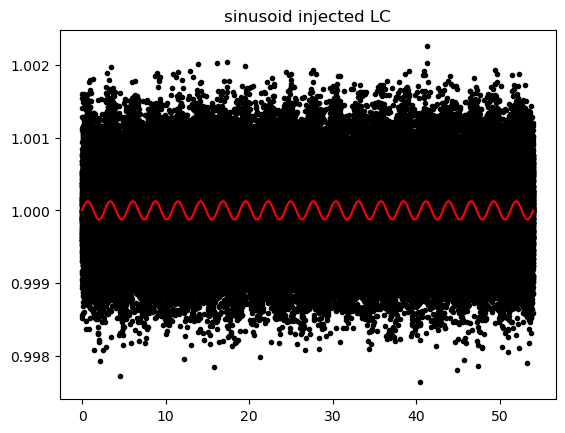

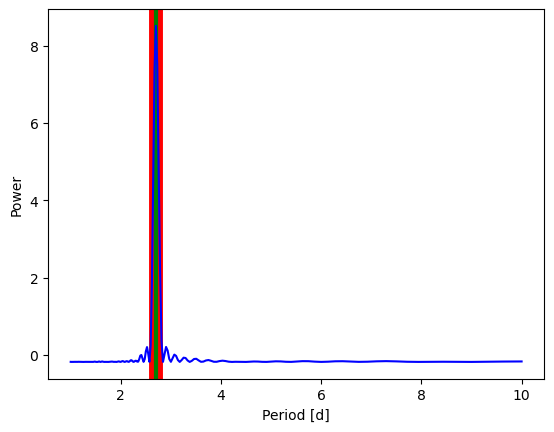

In [3]:
# simulate TESS LC
import pandas as pd
import numpy as np

def mag_to_flux(t, mag, exptime=30.0 / 60.0 / 24.0, zeropoint=20.44):
    # make sure the average is photon-weighted (as opposed to magnitude weighted)
    flux = 10 ** (-0.4 * (mag - zeropoint))
    flux = flux*np.ones_like(t) / 1e6
    return flux

def periodic_singal(A,T,t):
    from astropy.modeling.functional_models import Sine1D
    s1 = Sine1D(amplitude=A,frequency=(1.0/T))    
    signal = s1(t)
    return signal


def alt_photometry(tmin,tmax,cadence,scatter_frac,jd_ref): #not based on mag at all
    ndays = tmax #days
    pts_per_day = 24*cadence #data points per day

    start=tmin
    stop=ndays
    stepsize=ndays*pts_per_day
    t = jd_ref +  np.arange(tmin, tmax, cadence)#np.linspace(start, stop, int(stepsize)) 

    flux = 1.0 + np.random.randn(t.size) * scatter_frac
    fluxerr = np.ones_like(flux) * scatter_frac
    
    return t,flux,fluxerr


# def lightcurve(tmin,tmax,cadence,mag,A,T,zeropoint):
def lightcurve(tmin,tmax,cadence,scatter_frac,A,T):    
#     t = np.arange(tmin, tmax, cadence)
#     flux = mag_to_flux(t,mag, exptime=cadence, zeropoint=zeropoint)
#     flux = 1.0 + np.random.randn(t.size) * flux

    jd_ref=0.0
    t,flux,flux_err= alt_photometry(tmin,tmax,cadence,scatter_frac,jd_ref)
    
    periodic_signal = periodic_singal(A,T,t)+np.nanmedian(flux)
    injected_signal = (flux + periodic_signal - np.nanmedian(flux)) / np.nanmedian(flux)
#     injected_signal=flux
    
    return t, injected_signal, periodic_signal, flux_err

tmin=0
tmax=27*2

mag=10
scatter_frac=0.0005
cadence = 25/60/60/24
zeropoint=20.44
T = 2.7 #rotation period (days)
A = scatter_frac/4

t, injected_signal, periodic_signal,flux_err = lightcurve(tmin,tmax,cadence,scatter_frac,A,T)

print('cadence check',cadence*24*60,np.nanmedian(np.diff(t))*24*60)


from matplotlib import pyplot as plt
plt.title('sinusoid injected LC')
plt.plot(t,injected_signal,'k.')
plt.plot(t,periodic_signal,'r-')
plt.show()


from astropy.timeseries import LombScargle
frequency, power = LombScargle(t, injected_signal).autopower(minimum_frequency=1/10,
                                                             maximum_frequency=1,
                                                             normalization='standard')
period = 1/frequency


plt.axvline(x=T,color='red',lw=10)
plt.axvline(x=period[np.argmax(power)],color='green',lw=3)
plt.plot(period,(power-np.nanmean(power))/np.nanstd(power),'b-')
plt.xlabel('Period [d]')
plt.ylabel('Power')
plt.show()

In [4]:
# THIS DOESN'T WORK WELLLLLLL

# def quasi_periodic_singal(A, l, G, P, m, s, c, t):
#     #A, amp
#     #l, characteristic length
#     #G, amp of 2nd sine wave ?
#     #P,  rotation period
#     #m, slope
#     #s, scale factor?
#     #c, normalization factor?
#     #t, time
#     f = (A**2) * (np.exp(- t**2/(2 * l**2) - G**2 * np.sin(np.pi*t/P)**2)) + m*t #orig
#     return (f / f[0]) * s + c


# def lightcurveV2(tmin,tmax,cadence,scatter_frac, A, l, G, P, m, s, c):    
# #     t = np.arange(tmin, tmax, cadence)
# #     flux = mag_to_flux(t,mag, exptime=cadence, zeropoint=zeropoint)
# #     flux = 1.0 + np.random.randn(t.size) * flux

#     jd_ref=0.0
#     t,flux,flux_err= alt_photometry(tmin,tmax,cadence,scatter_frac,jd_ref)
    
#     periodic_signal = quasi_periodic_singal(A, l, G, P, m, s, c, t)
#     injected_signal = (flux + periodic_signal - np.nanmedian(flux)) / np.nanmedian(flux)
# #     injected_signal=flux
    
#     return t, injected_signal, periodic_signal, flux_err

# A, l, G, P, m, s, c= [np.exp(1), np.exp(10), np.exp(.1), 19.514, -0.07, 0.5, 0.55]
# A = 3 #np.exp(1)
# l = np.exp(1e1)
# G = np.exp(1e-1)
# P = T*3
# m = 2.5e-2
# s = 4e-1
# c = s*1.75
# t2, injected_signal2, periodic_signal2, flux_err2 = lightcurveV2(tmin,tmax,cadence,scatter_frac, A, l, G, P, m, s, c)


# plt.plot(t2,injected_signal2,'k.')
# plt.plot(t2,periodic_signal2,'r-')

# plt.show()



In [5]:
def simulate_flares(time, flux, flare_rate,alpha=None, newTemplate=False):
    from FlareInjection import generate_flare_parameters,generate_flare,equivalent_duration
    time = np.array(time)
    input_median = np.nanmedian(flux)

#     # Generate copy of flux so the original is not overwritten:
#     flux = copy.deepcopy(flux)

    # Input and LC parameters:
    lc_len = len(time)  # LC length, in data points TODO: Do I need this?
    lc_dur = time[-1] - time[0]  # LC duration, in days
    n_flares = int(np.round(flare_rate * lc_dur))  # Total number of flares to be injected    

    # List with dictionaries of injection parameters, will be filled throughout the process:
    flare_params = []

    for i in range(n_flares):  # Loop over all flares to be injected
        params_dict = {}

        #
        # First generate flare parameters: Duration, start time, amplitude.
        flare_dur_mins, flare_dur_days, flare_start, amp = generate_flare_parameters(time, lc_dur,alpha)
        flare_end = flare_start + flare_dur_days  # Help variable

        #
        # Next, get indices of where the flare will be:
        cond = np.logical_and(time >= flare_start, time <= flare_end)
        flare_inds = np.argwhere(cond).flatten()
        
        if len(flare_inds) == 0:  # Flare might be very short and in between two data points.
            logging.debug(f'Flare number {i+1} is between two data points:'
                          f'\n\tStart: {flare_start:.2f}\n\tLength:{flare_dur_mins:.2f} mins')
            cond = time >= flare_start
            flare_inds = np.argwhere(cond)[0:1].flatten()  # Flare index corresponds to only one data point
        
        #
        # Now generate the flare data:
        t_flare = time[flare_inds]  # Time array of the flare
        t_max = flare_start + flare_dur_days / 13  # Theoretical peak of the flare, at 1/13 flare length

        # Generate flux data of the injected flare
        if newTemplate:
            flare_flux = generate_flare_new(t_flare, flare_start, t_max, amp)
        else:
            flare_flux = generate_flare(t_flare, flare_start, t_max, amp)
        
        ED = equivalent_duration(t_flare, flare_flux,input_median)  # Calculate equivalent duration of the flare

        #flux[flare_inds] += flare_flux  # Add flare flux to regular lc flux.
    
        params_dict['Indices'] = flare_inds
        params_dict['tstart'] = flare_start
        params_dict['tpeak'] = t_max
        params_dict['tstop'] = flare_end
        params_dict['dur'] = flare_dur_days # in days ,not minutes
        params_dict['Fpeak'] = amp
        params_dict['Npts'] = len(t_flare)
        params_dict['equiv_dur'] = ED
        flare_params.append(params_dict)  # Append dictionary to list of all flares

    return flare_params


def inject_simulated_flares(inj_flare_params,time,flux,newTemplate=False):
    from FlareInjection import generate_flare_parameters,generate_flare,generate_flare_new,equivalent_duration
    import copy
    inj_flux = copy.deepcopy(flux)
    time = copy.deepcopy(time)
    print(f'{len(inj_flare_params)} flares will be injected.')
    
    for ii in range(len(inj_flare_params)):
        flare_inds = inj_flare_params['Indices'][ii]
        flare_start= inj_flare_params['tstart'][ii]
        t_max =  inj_flare_params['tpeak'][ii]
        amp =  inj_flare_params['Fpeak'][ii]
        t_flare = time[flare_inds]
        if newTemplate:
            flare_flux = generate_flare_new(t_flare, flare_start, t_max, amp)
        else:
            flare_flux = generate_flare(t_flare, flare_start, t_max, amp)
        inj_flux[flare_inds]+=flare_flux
        
    return inj_flux

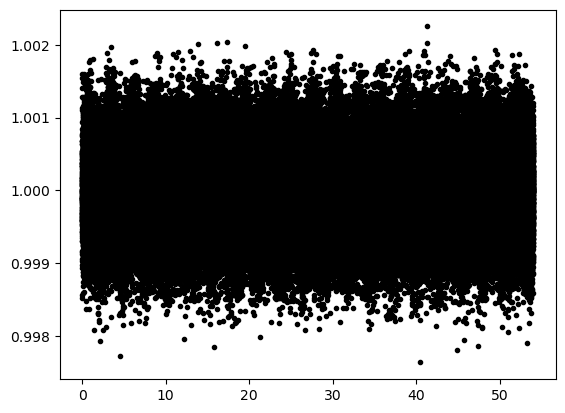

270 flares will be injected.


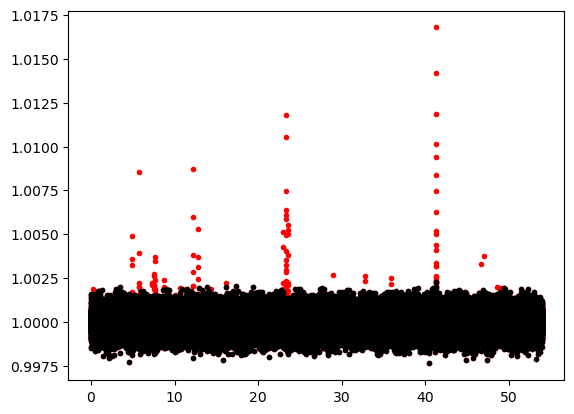

34 flares will be injected.


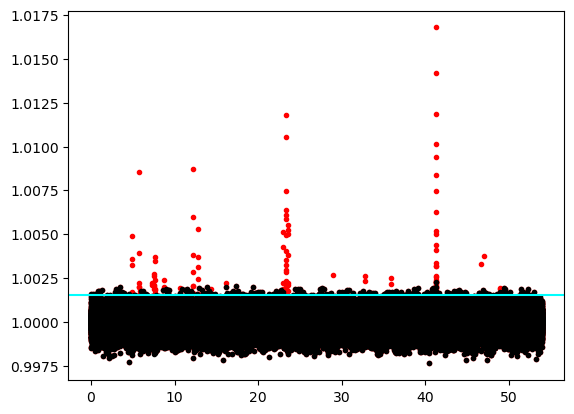

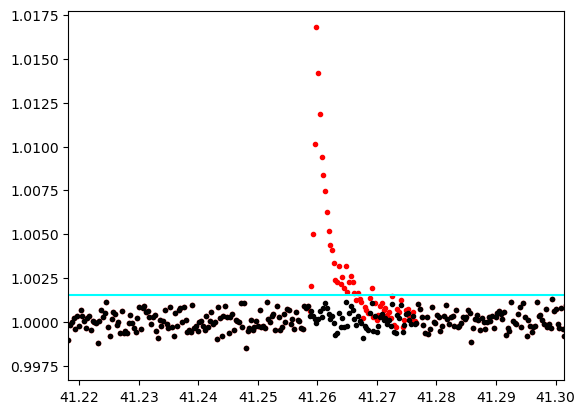

In [6]:
flare_rate = 5 #per day

time=t
flux=injected_signal

plt.plot(time,flux,'k.')
plt.show()

test_flare_inj_params = simulate_flares(time, flux, flare_rate)
test_flare_inj_params = pd.DataFrame(test_flare_inj_params)
test_inj_flux = inject_simulated_flares(test_flare_inj_params,time,flux)

plt.plot(time,test_inj_flux,'r.')
plt.plot(time,flux,'k.')
plt.show()

lcnoise=3*np.nanstd(flux)
test_flare_inj_params2 = test_flare_inj_params.loc[test_flare_inj_params['Fpeak']>=lcnoise].reset_index(drop=True)
test_inj_flux2 = inject_simulated_flares(test_flare_inj_params2,time,flux)

plt.plot(time,test_inj_flux2,'r.')
plt.plot(time,flux,'k.')
plt.axhline(y=np.nanmedian(flux)+lcnoise,color='cyan')
plt.show()


plt.plot(time,test_inj_flux2,'r.')
plt.plot(time,flux,'k.')
plt.axhline(y=np.nanmedian(flux)+lcnoise,color='cyan')
plt.xlim(time[np.argmax(test_inj_flux2)]-1/24,
         time[np.argmax(test_inj_flux2)]+1/24)
plt.show()


injected flare rate:  5  per day
270 flares will be injected.


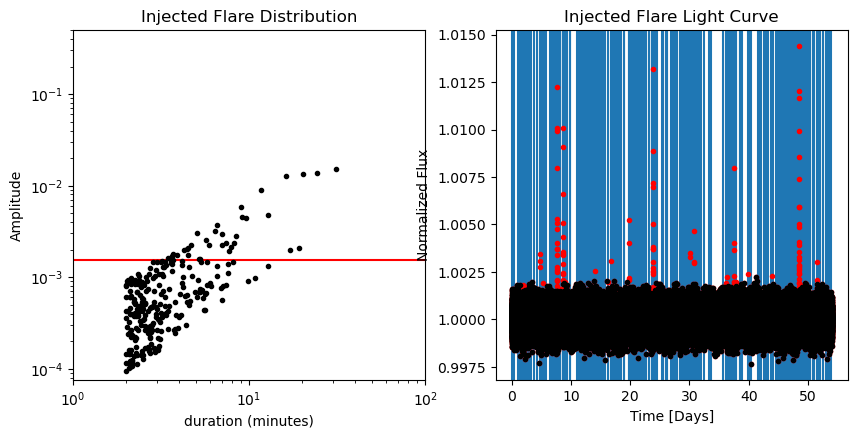

Number of flares below 3 std of simulated flux:
235 / 270 = 87.03703703703704 %
Number of flares above 3 std of simulated flux:
35 / 270 = 12.962962962962962 %


In [7]:
# inject flares with Tobias' code:
time=t
flux=injected_signal

lc_noise = 3*np.nanstd(flux) #+ np.nanmedian(flux)

flare_rate = 5 #per day
print('injected flare rate: ',flare_rate,' per day')
inj_flux, inj_flare_params= inject_flares(time, flux, flare_rate)#, newTemplate=False)

inj_flare_params=pd.DataFrame(inj_flare_params)



fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax1.plot(inj_flare_params['dur']*24*60,inj_flare_params['Fpeak'],'k.')
ax1.set_xlim(1,100)
ax1.set_ylim(0.000075,0.5)
ax1.axhline(y=lc_noise,zorder=-10,color='red')
ax1.axvline(x=cadence*24*60,zorder=-10,color='red')
ax1.set_xlabel('duration (minutes)')
ax1.set_ylabel('Amplitude')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(time,inj_flux,'r.')
ax2.plot(time,flux,'k.')
for x in range(len(inj_flare_params)):
    ax2.axvline(x=inj_flare_params['tstart'][x],zorder=-10)
    
ax1.set_title('Injected Flare Distribution')
ax2.set_title('Injected Flare Light Curve')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Time [Days]')
plt.show()


print('Number of flares below 3 std of simulated flux:')
print(len(inj_flare_params.loc[inj_flare_params['Fpeak'] <= lc_noise]),'/',len(inj_flare_params),\
      '=',len(inj_flare_params.loc[inj_flare_params['Fpeak'] <= lc_noise])/len(inj_flare_params)*100,'%')


print('Number of flares above 3 std of simulated flux:')
print(len(inj_flare_params.loc[inj_flare_params['Fpeak'] >= lc_noise]),'/',len(inj_flare_params),\
      '=',len(inj_flare_params.loc[inj_flare_params['Fpeak'] >= lc_noise])/len(inj_flare_params)*100,'%')

In [8]:
print('min/max inj amp',np.min(inj_flare_params['Fpeak']),np.max(inj_flare_params['Fpeak']))

min/max inj amp 9.503947153192173e-05 0.015188408958586582


In [9]:
inj_flare_params.head(1)

,Indices,tstart,tpeak,tstop,dur,Fpeak,Npts,equiv_dur
0,"[165833, 165834, 165835, 165836, 165837, 16583...",47.983871,47.984105,47.986912,0.00304,0.000297,10,0.002604


Parameters([('norm', <Parameter 'norm', value=57.79848957636957 +/- 2.12, bounds=[-inf:inf]>)])


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_10516/1548241163.py:332: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


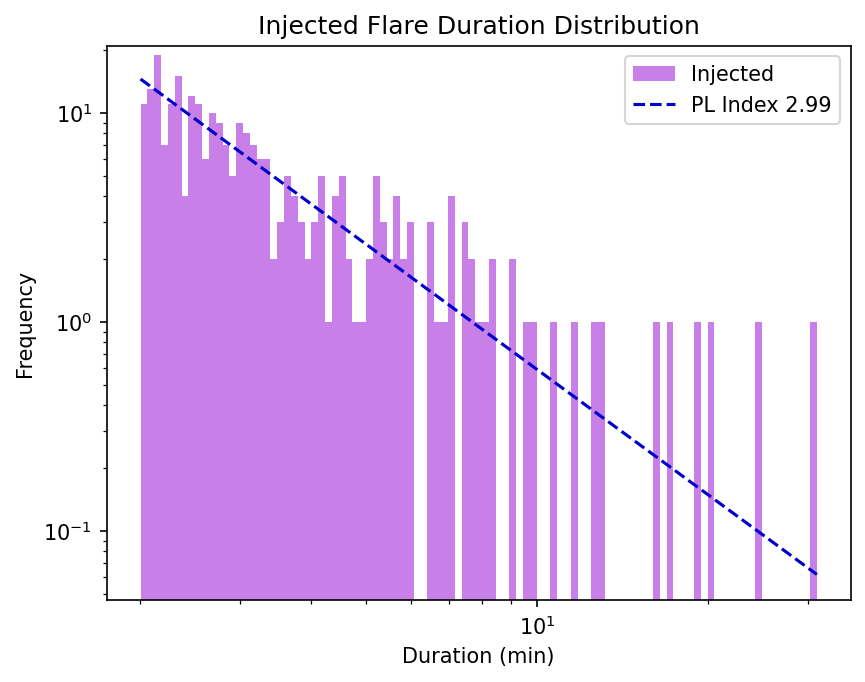

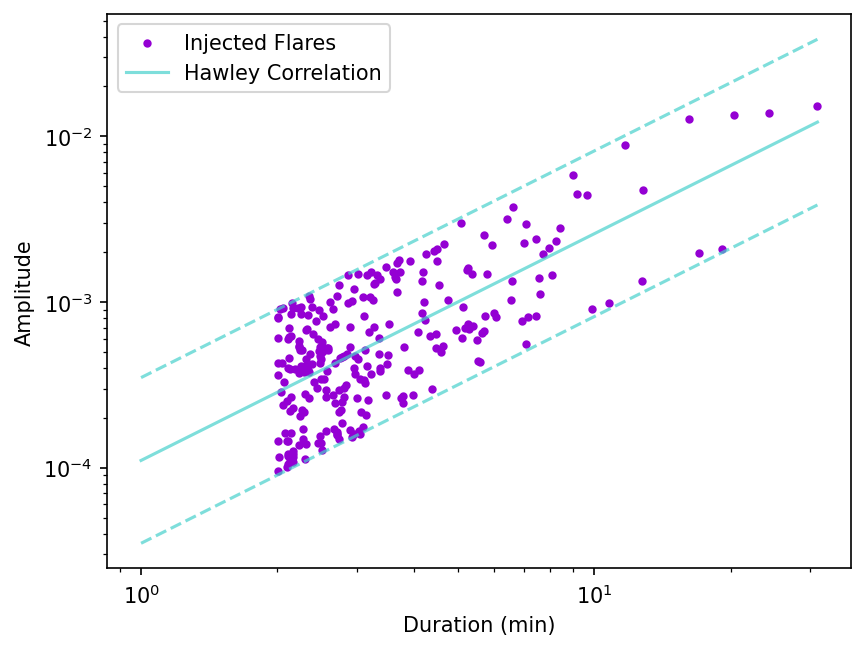

In [10]:
filename1='duration_distribution.png'
filename2='hawley_relation.png'

plotDurationDistribution(params_dict=inj_flare_params,savePath=filename1)
plotHawleyRelation(params_dict=inj_flare_params,savePath=filename1)

In [11]:
inj_flare_params.head(1)

,Indices,tstart,tpeak,tstop,dur,Fpeak,Npts,equiv_dur
0,"[165833, 165834, 165835, 165836, 165837, 16583...",47.983871,47.984105,47.986912,0.00304,0.000297,10,0.002604


# try only including flares above the noise


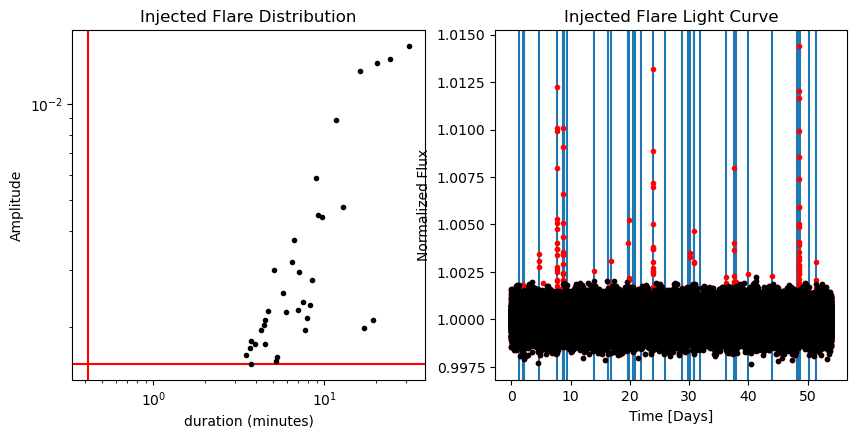

Parameters([('norm', <Parameter 'norm', value=12.873051657913656 +/- 2.01, bounds=[-inf:inf]>)])


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_10516/1548241163.py:332: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


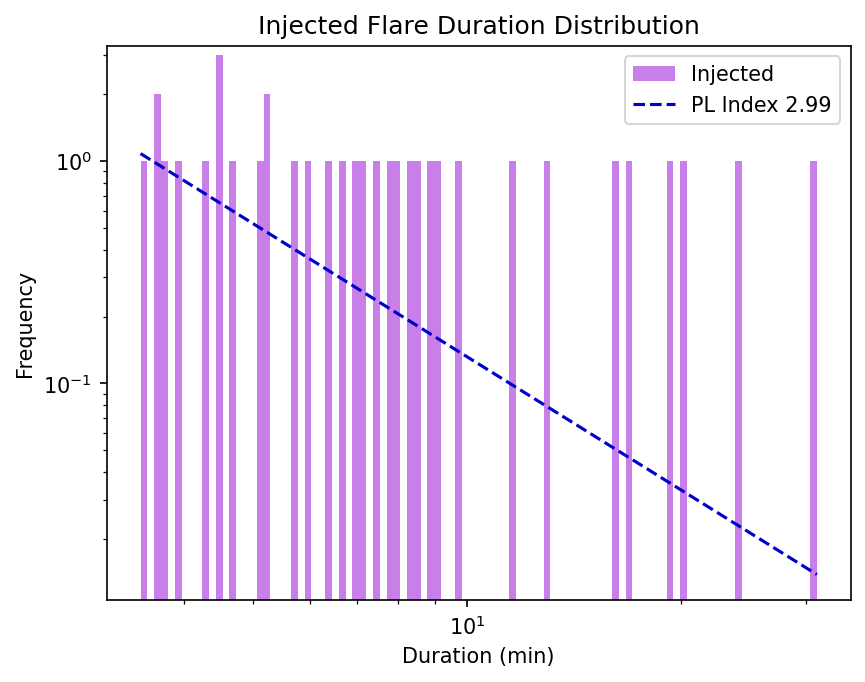

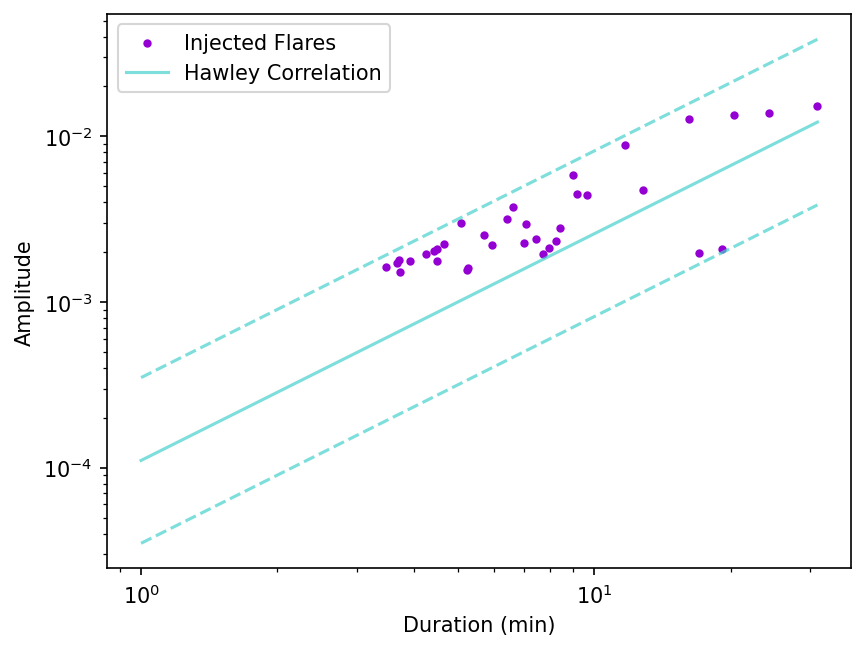

In [12]:


inj_flare_params = inj_flare_params.loc[inj_flare_params['Fpeak'] >= lc_noise].reset_index(drop=True)


fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax1.plot(inj_flare_params['dur']*24*60,inj_flare_params['Fpeak'],'k.')
ax1.axhline(y=lc_noise,zorder=-10,color='red')
ax1.axvline(x=cadence*24*60,zorder=-10,color='red')
ax1.set_xlabel('duration (minutes)')
ax1.set_ylabel('Amplitude')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(time,inj_flux,'r.')
ax2.plot(time,flux,'k.')
for x in range(len(inj_flare_params)):
    ax2.axvline(x=inj_flare_params['tstart'][x],zorder=-10)
    
ax1.set_title('Injected Flare Distribution')
ax2.set_title('Injected Flare Light Curve')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Time [Days]')
plt.show()


filename1='duration_distribution_below_lc_noise.png'
filename2='hawley_relation_below_lc_noise.png'

plotDurationDistribution(params_dict=inj_flare_params,savePath=filename1)
plotHawleyRelation(params_dict=inj_flare_params,savePath=filename1)

In [13]:
# does equiv dur make sense? It should be close-ish to dur (I think)
T0 = time[np.argmax(inj_flux)]

print(np.round(np.nanmedian(inj_flux)))

inj_temp = inj_flare_params.loc[(inj_flare_params['tpeak']>=T0-0.5/24) & (inj_flare_params['tpeak']<=T0+0.5/24)]
inj_temp[['dur','equiv_dur']]

1.0


,dur,equiv_dur
18,0.021589,0.021457


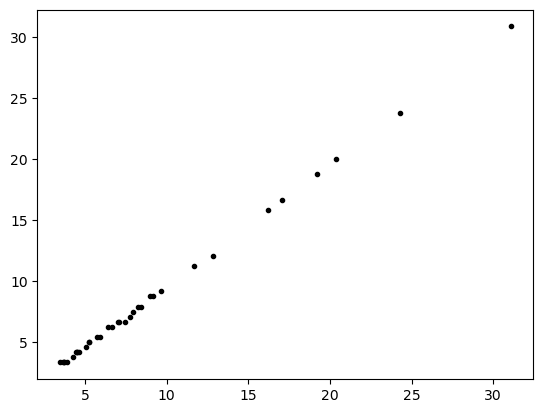

In [14]:
plt.plot(inj_flare_params['dur']*24*60,inj_flare_params['equiv_dur']*24*60,'k.')
# plt.plot(np.linspace(0,30),np.linspace(0,30),'r-')
# plt.xl
plt.show()

In [15]:
print('min/max inj amp',np.min(inj_flare_params['Fpeak']),np.max(inj_flare_params['Fpeak']))

min/max inj amp 0.0015268902917901486 0.015188408958586582


In [16]:
print(len(inj_flare_params),'injected flares')

35 injected flares


# put it all together

In [17]:
#make savepath
import os,sys
savepath_for_flare_injected_LCs='/Users/daxfeliz/Desktop/PLATO/testing/Dax_Simulated_PLATO_flares/injections/'
if os.path.exists(savepath_for_flare_injected_LCs)==True:
    pass
else:
    os.makedirs(savepath_for_flare_injected_LCs)


#function for creating injected flare    
def injected_flares(savepath,ID,
                    tmin,tmax,cadence,scatter_frac,A,T,
                    flare_rate):
    
    #simulated light curve
    t, injected_signal, periodic_signal,flux_err = lightcurve(tmin,tmax,cadence,scatter_frac,A,T)
    from astropy.timeseries import LombScargle
    
    frequency, power = LombScargle(t, injected_signal).autopower(minimum_frequency=1/(tmax/3),
                                                                 maximum_frequency=1,
                                                                 normalization='standard')
    period = 1/frequency    

    print('cadence check',cadence*24*60,np.nanmedian(np.diff(t))*24*60)


    from matplotlib import pyplot as plt
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)
    ax3=fig.add_subplot(223)
    ax4=fig.add_subplot(224)    
    ax1.set_title('sinusoid injected LC')
    ax1.plot(t,injected_signal,'k.')
    ax1.plot(t,periodic_signal,'r-')
    ax1.set_xlabel('time')
    ax1.set_ylabel('flux')
    ax2.axvline(x=T,color='red',lw=10)
    ax2.axvline(x=period[np.argmax(power)],color='green',lw=3)
    ax2.plot(period,(power-np.nanmean(power))/np.nanstd(power),'b-')
    ax2.set_xlabel('Period [d]')
    ax2.set_ylabel('Power')
    ax2.set_title('Lomb-Scargle Search')

    
    
    #simulating and injecting flares
    time=t
    flux=injected_signal

    lc_noise = 3*np.nanstd(flux)

    print('injected flare rate: ',flare_rate,' per day')
    
    inj_flare_params = simulate_flares(time, flux, flare_rate)
    inj_flare_params = pd.DataFrame(inj_flare_params)
    
#     inj_flux, inj_flare_params= inject_flares(time, flux, flare_rate)#, newTemplate=False)
#     inj_flare_params=pd.DataFrame(inj_flare_params)
    
    inj_flare_params_above_3_sigma = inj_flare_params.loc[inj_flare_params['Fpeak'] >= lc_noise].reset_index(drop=True)
    inj_flare_params_below_3_sigma = inj_flare_params.loc[inj_flare_params['Fpeak'] <= lc_noise].reset_index(drop=True)
    
    
    inj_flux = inject_simulated_flares(inj_flare_params_above_3_sigma,time,flux)

    s1 = r'>= 3$\sigma$: '+str(len(inj_flare_params_above_3_sigma))+'/'+str(len(inj_flare_params))+' = '+str(np.round(len(inj_flare_params_above_3_sigma)/len(inj_flare_params)*100,3))+'%'
    
    s2 = r'<= 3$\sigma$: '+str(len(inj_flare_params_below_3_sigma))+'/'+str(len(inj_flare_params))+' = '+str(np.round(len(inj_flare_params_below_3_sigma)/len(inj_flare_params)*100,3))+'%'


    ax3.plot(inj_flare_params['dur']*24*60,inj_flare_params['Fpeak'],'k.')
    ax3.scatter(x=inj_flare_params_above_3_sigma['dur']*24*60,y=inj_flare_params_above_3_sigma['Fpeak'],
                color='red',s=3,zorder=10)
    ax3.set_xlim(1,100)
    ax3.set_ylim(0.000075,0.5)
    ax3xmin,ax3xmax=ax3.get_xlim()
    ax3ymin,ax3ymax=ax3.get_ylim()
    xpos=ax3xmin+0.1*ax3xmin
    ypos1=ax3ymax/2
    ypos2=ax3ymax/2-(ax3ymax/2)*0.5
    ax3.annotate(text=s1,xy=(xpos,ypos1),xytext=(xpos,ypos1))
    ax3.annotate(text=s2,xy=(xpos,ypos2),xytext=(xpos,ypos2))
    ax3.axhline(y=lc_noise,zorder=-10,color='cyan')
    ax3.axvline(x=cadence*24*60,zorder=-10,color='cyan')
    

    def hawley_amp(dur):
        log_amp = 1.3681783243659 * np.log10(dur) - 3.9563566487317
        return 10 ** log_amp

    x = np.linspace(1, 100, 250)
    theo_color = 'green'
    theo_alpha = 0.7
    ax3.plot(x, hawley_amp(x), color=theo_color, alpha=theo_alpha, label='Hawley Correlation')
    ax3.plot(x, hawley_amp(x) * 10 ** 0.5, ls='--', color=theo_color, alpha=theo_alpha)
    ax3.plot(x, hawley_amp(x) * 10 ** (-0.5), ls='--', color=theo_color, alpha=theo_alpha)    
    
    ax3.set_xlabel('duration (minutes)')
    ax3.set_ylabel('Amplitude')
    ax3.set_yscale('log')
    ax3.set_xscale('log')

    ax4.plot(time,inj_flux,'r.')
    ax4.plot(time,flux,'k.')
    ax4.axhline(y=np.nanmedian(flux)+lcnoise,color='cyan')
    for x in range(len(inj_flare_params)):
        ax4.axvline(x=inj_flare_params['tstart'][x],zorder=-10)

    ax3.set_title('Injected Flare Distribution')
    ax4.set_title('Injected Flare Light Curve')
    ax4.set_ylabel('Normalized Flux')
    ax4.set_xlabel('Time [Days]')
    fig.suptitle('LC Simulated # '+str(ID),y=0.915)
    fig.tight_layout(pad=1)
    fig.savefig(savepath_for_flare_injected_LCs+'lc_simulated_'+str(ID)+'.png',bbox_inches='tight')
    plt.show()
    
    
    input_LC = pd.DataFrame({'time':time,
                            'flux':inj_flux,
                            'flux_err':flux_err})
#     input_LC.to_csv(savepath+'lc_simulated_'+str(ID)+'_flare_injected_LC.csv',index=False)
    
#     inj_flare_params_above_3_sigma.to_csv(savepath+'lc_simulated_'+str(ID)+'_flare_injected_params.csv',index=False)
    

    
    
    
    
    

# simulate 5 LCs

simulated LC params:
scatter_frac: 0.0009503103955664398
Prot: 7.517761069575147
amplitude: 0.0003582650872806882
Flare rate: 9.852878088029284
cadence check 0.41666666666666674 0.4166666666657193
injected flare rate:  9.852878088029284  per day
26 flares will be injected.


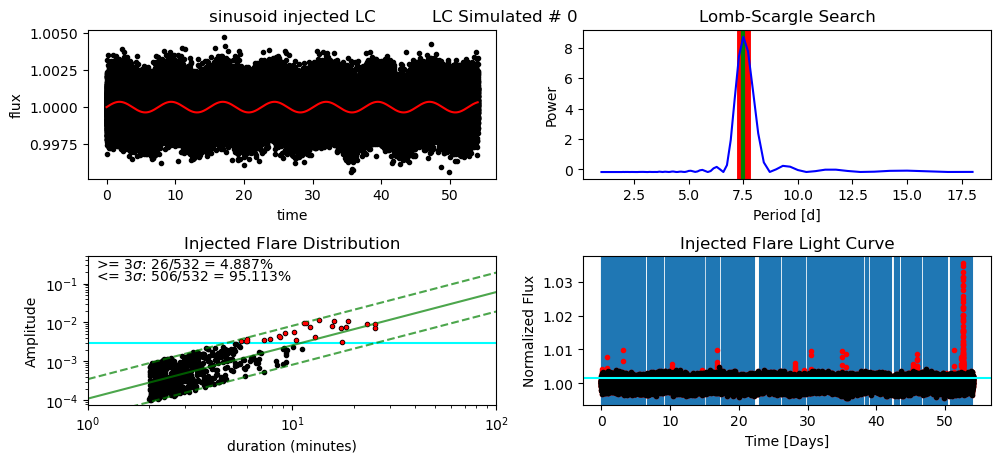

simulated LC params:
scatter_frac: 0.000711594798914271
Prot: 4.536946509720112
amplitude: 0.00026104997129275517
Flare rate: 9.21904871143333
cadence check 0.41666666666666674 0.4166666666657193
injected flare rate:  9.21904871143333  per day
41 flares will be injected.


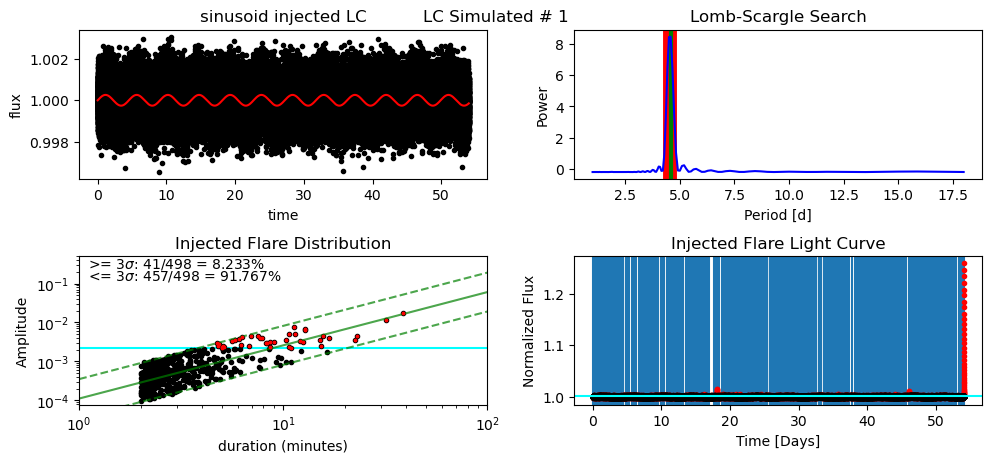

simulated LC params:
scatter_frac: 0.0008184256873432014
Prot: 4.219731264757849
amplitude: 0.00031055364678418733
Flare rate: 7.628326046026042
cadence check 0.41666666666666674 0.4166666666657193
injected flare rate:  7.628326046026042  per day
29 flares will be injected.


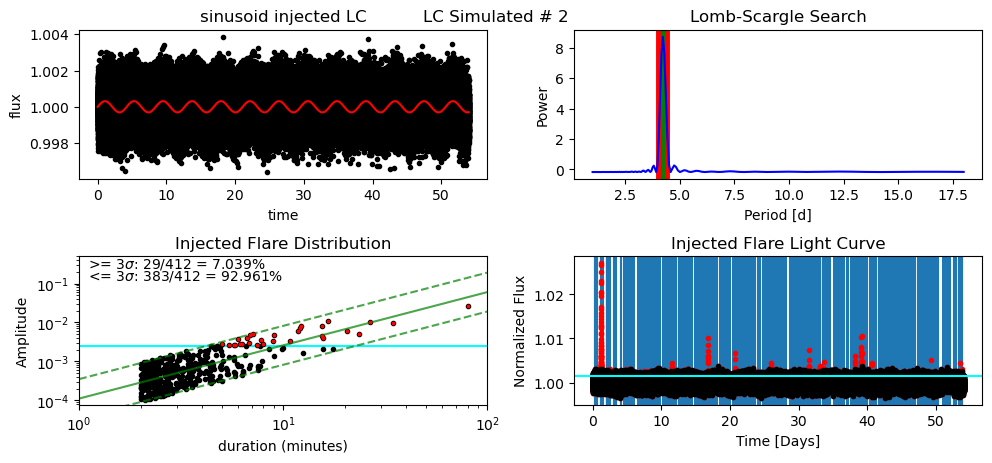

simulated LC params:
scatter_frac: 0.0006773686307991384
Prot: 6.392900755350936
amplitude: 0.00021983323999068266
Flare rate: 6.6893707824761
cadence check 0.41666666666666674 0.4166666666657193
injected flare rate:  6.6893707824761  per day
24 flares will be injected.


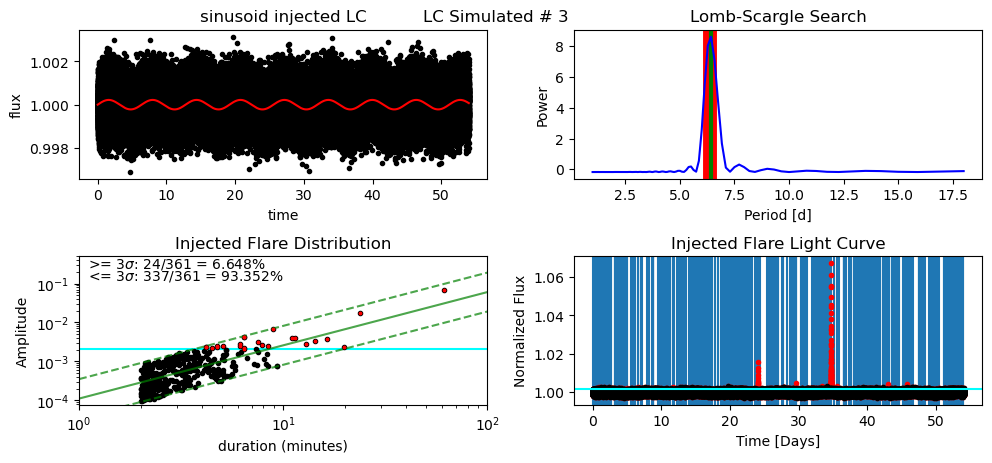

simulated LC params:
scatter_frac: 0.0007227220665561473
Prot: 6.929187186349281
amplitude: 0.00022260239542206534
Flare rate: 8.90295986231866
cadence check 0.41666666666666674 0.4166666666657193
injected flare rate:  8.90295986231866  per day
41 flares will be injected.


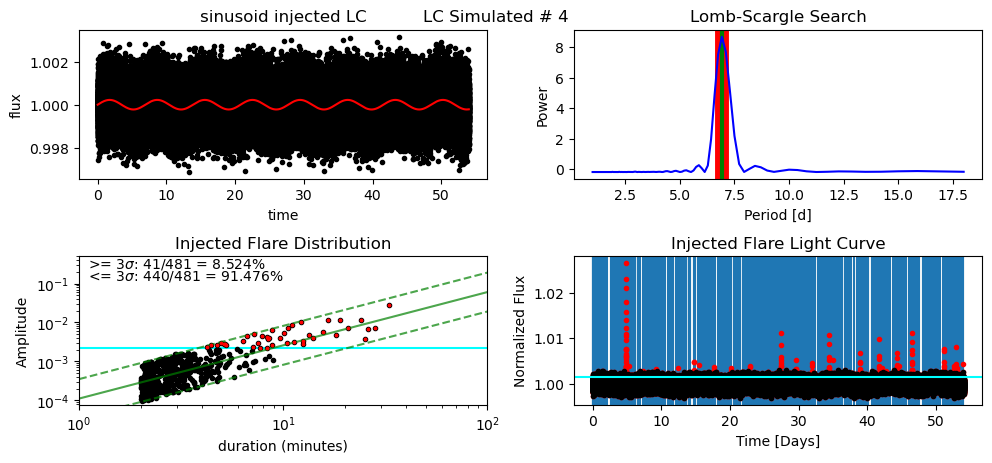

In [18]:
tmin=0
tmax=27*2
cadence = 25/60/60/24
zeropoint=20.44
mag=10


for x in range(5):
    ID=int(x)
    
    scatter_frac=np.random.uniform(5e-4,1e-3)#0.00025
    Prot = np.random.uniform(1,tmax/5) #rotation period (days)
    A = np.random.uniform(scatter_frac/4,scatter_frac/2)  #amplitude 
    flare_rate=np.random.uniform(5,10) #per day
    
    
    print('simulated LC params:')
    print('scatter_frac:',scatter_frac)
    print('Prot:',Prot)
    print('amplitude:',A)
    print('Flare rate:',flare_rate)
    
    injected_flares(savepath_for_flare_injected_LCs,ID,
                        tmin,tmax,cadence,scatter_frac,A,Prot,
                        flare_rate)
    

# check largest and smallest flares and noise level AFTER injection


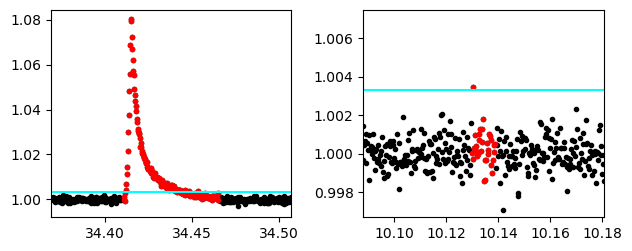

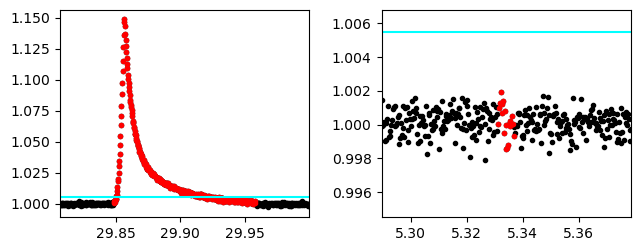

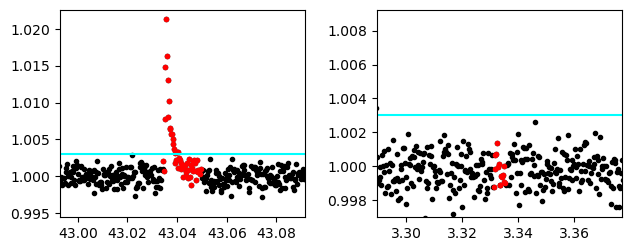

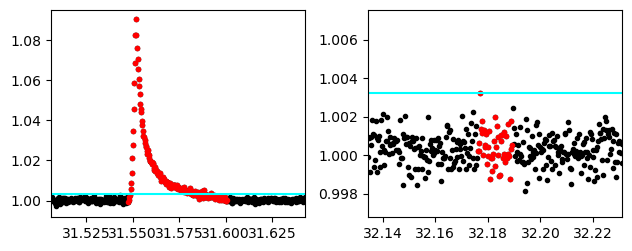

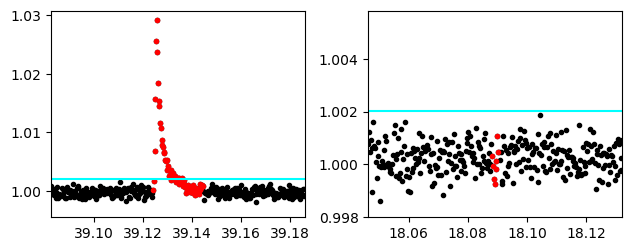

In [19]:
Nstd=3

for x in range(5):
    ID=int(x)
    LC=pd.read_csv(savepath_for_flare_injected_LCs+'lc_simulated_'+str(ID)+'_flare_injected_LC.csv')    
    injected_flare_params=pd.read_csv(savepath_for_flare_injected_LCs+'lc_simulated_'+str(ID)+'_flare_injected_params.csv')
    
    
    big_flare = injected_flare_params.loc[injected_flare_params['Fpeak']==np.max(injected_flare_params['Fpeak'])]
    big_flare_pts = LC.loc[(LC['time']>=big_flare['tstart'].item()) & (LC['time']<=big_flare['tstop'].item())]
    small_flare = injected_flare_params.loc[injected_flare_params['Fpeak']==np.min(injected_flare_params['Fpeak'])]
    small_flare_pts = LC.loc[(LC['time']>=small_flare['tstart'].item()) & (LC['time']<=small_flare['tstop'].item())]
    
    
    fig=plt.figure()
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)    
    ax1.plot(LC['time'],LC['flux'],'k.')
    ax1.plot(big_flare_pts['time'],big_flare_pts['flux'],'r.')
    ax1.set_xlim(big_flare['tstart'].item()-1/24,big_flare['tstop'].item()+1/24)
    
    ax2.plot(LC['time'],LC['flux'],'k.')
    ax2.plot(small_flare_pts['time'],small_flare_pts['flux'],'r.')
    ax2.set_xlim(small_flare['tstart'].item()-1/24,small_flare['tstop'].item()+1/24)
    ax2.set_ylim(np.nanmedian(LC['flux'])-3*np.nanstd(LC['flux']),
                np.nanmedian(LC['flux'])+3*small_flare['Fpeak'].item())
    
    ax1.axhline(y=np.nanmedian(LC['flux'])+Nstd*np.nanstd(LC['flux']),color='cyan')
    ax2.axhline(y=np.nanmedian(LC['flux'])+Nstd*np.nanstd(LC['flux']),color='cyan')
    
    fig.tight_layout(pad=1)
    plt.show()
    
    

In [20]:
print('done!')

done!
